### Before start web scraping we have examined the web page with the instrument 'inspects'. As we see all the information are inside the HTML class 'listing-item_body--content'; we have build our script to download data finding all 'li' class element inside the previous class which contain all the required data. BeautifulSoup library is used in order to perform all these action.

![](https://github.com/DanSan23/HOMEWORK-4-immobiliare.it/blob/master/Image/Web%20site%20structure.jpg?raw=true)

#### Import library

In [ ]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, regexp_tokenize
import numpy as np
import time
from sklearn.cluster import KMeans
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

## Parsing page with BeautifulSoup

Get data from website using $requests$ library and create a $BeautifulSoup$ element to parse web pages.

In [ ]:
#create lists where store the data
title=[]
price=[]
n_room=[]
mq=[]
n_bathroom=[]
plan=[]
desc=[]
i=1
#iterate to take data from different page
for num in tqdm(range(1,1728)):
    url = str('www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag='+str(num))
    r = requests.get('https://' +url)
    data = r.text
    soup = BeautifulSoup(data,'html.parser')

    #iterate on the main class which contain all the data 
    for announcement in tqdm(soup.find_all('div', class_='listing-item_body--content')):
        #find all 'li' class which contain the data that we want and store them inside the lists
        feature = announcement.find_all('li')
        #check if we have all the feature required because some announcement are not complete
        if len(feature)>=5:
            #filter word on price
            feature_price = feature[0].text.strip()
            if ('PREZZO SU RICHIESTA' in feature_price )== True:
                break
            elif('%' in feature_price) == True:
                #remove undesired character
                feature_price = feature_price.replace('.','').replace('€','').replace(' ','')
                #slice in order to take the desired number
                price.append(feature_price[-19:-12])
            else:
                feature_price = feature_price.replace('.','').replace('€','').replace(' ','')
                price.append(feature_price)
            feature_n_room = feature[1].text[0]
            n_room.append(feature_n_room)
            feature_mq = feature[2].text[0:-12].replace('\xa0','')
            mq.append(feature_mq)
            feature_n_bathroom = feature[3].text[0:-5].replace('+','').replace('\xa0','')
            n_bathroom.append(feature_n_bathroom)
            feature_plan = feature[4].text[0:-7].strip()
            #check if there is a character inside plan data, if yes pop last elements 
            if feature_plan.isalpha()==True:
                #title.pop()
                price.pop()
                n_room.pop()
                mq.pop()
                n_bathroom.pop()
                i+=0

            else:    
                plan.append(feature_plan)

                #find <a element where <href is present
                link=announcement.find('a', href=True)
                #check to solve the problem where the <href didn't have the complete link
                if ('https://' in link['href'])==True:
                    ann=requests.get(link['href'])
                else:
                    ann=requests.get('https://www.immobiliare.it'+link['href'])
                data1 = ann.text
                #create another bs4 element with the objective of taking commplete text from announcement
                soup1 = BeautifulSoup(data1,'html.parser')
                #access to link and take complete text
                a=soup1.find('div', attrs={'role':'contentinfo'}).text.strip()
                desc.append(a)
                title.append('announcement_'+str(i))
                i+=1


    time.sleep(1)

### Load the list

After download all announcement we have save all lists. If you want to try the code run the follow cell after download the files (files are stored in folder DATA file in our repository).

In [39]:
with open(r'C:\Users\Daniele\Desktop\liste download\desc', 'rb') as f:
    desc = pickle.load(f)

with open(r'C:\Users\Daniele\Desktop\liste download\plan', 'rb') as f:
    plan = pickle.load(f)

with open(r'C:\Users\Daniele\Desktop\liste download\n_bathroom', 'rb') as f:
    n_bathroom = pickle.load(f)
    
with open(r'C:\Users\Daniele\Desktop\liste download\mq', 'rb') as f:
    mq = pickle.load(f)

with open(r'C:\Users\Daniele\Desktop\liste download\n_room', 'rb') as f:
    n_room = pickle.load(f)

with open(r'C:\Users\Daniele\Desktop\liste download\price', 'rb') as f:
    price = pickle.load(f) 
    
with open(r'C:\Users\Daniele\Desktop\liste download\title', 'rb') as f:
    title = pickle.load(f)

with open(r'C:\Users\Daniele\Desktop\liste download\processed_list', 'rb') as f:
    processed_list = pickle.load(f)    

The data are saved in a dictionary and stored in a pandas DataFrame, in this way we have created the first Dataset.

In [41]:
table=pd.DataFrame({'Annuncio':title,
                    'Prezzo':price,
                    'Camere':n_room,
                    'Superficie':mq,
                    'Bagni':n_bathroom,
                    'Piano':plan})
#used to remove a \n inside "Piano" coloumn
Information_cluster =table.set_index('Annuncio')
Information_cluster.head()

,Prezzo,Camere,Superficie,Bagni,Piano
Annuncio,,,,,
announcement_1,225000,2,50,1,1
announcement_2,395000,5,130,2,1
announcement_3,3700000,5,250,3,5
announcement_4,850000,5,175,2,5
announcement_5,279000,3,110,1,1


Function to preprocess all text in the announcement is now executed; it's a function which remove punctuation, undesired symbols,doing tokenization and stemming.

In [67]:
def preprocess(text):
    text = text.lower()
    # removing '\n'
    text = text.replace('\\n', ' ')
    # removing punctuation
    tokenizer = regexp_tokenize(text, "[\w\$]+")
    # filter the non stopwords
    filtered = [w for w in tokenizer if not w in stopwords.words('italian')]
    ps = PorterStemmer()
    # removing the stem
    filtered = [ps.stem(word) for word in filtered]
    return filtered

The preprocess function is now excuted for all announcement and the result is store in a list (in Data files folder, there is also this list)

In [ ]:
processed_list=[]
for i in tqdm(desc):
    processed_list.append(preprocess(i))    

Simply checking the number of unique word that we have.

In [69]:
flat_list = [item for sublist in processed_list for item in sublist]
len(list(set(flat_list)))

25421

The processed_list composed by a nested lists of words is converted to a list of strings and then a data frame with wordId and all text from the announcement processed is created.

In [118]:
#converting to list of strings
Converting=[' '.join(i) for i in processed_list]
#generate the wordId
WordId=[int(i) for i in range(1,len(Converting)+1)]
#creating dataframe with wordId and all text from the announcement processed
df1 = pd.DataFrame({'wordId': WordId, 'parole': Converting})

We have used pandas and numpy to compute $Tf-Idf$ in the previous generated dataframe

In [119]:
#Split and generate count vectors
word_vec = df1.parole.apply(str.split).apply(pd.value_counts).fillna(0)
# Compute term frequencies
tf = word_vec.divide(np.sum(word_vec, axis=1), axis=0)
# Compute inverse document frequencies
idf = np.log10(len(tf) / word_vec[word_vec > 0].count())
# Compute TF-IDF vectors
tfidf = np.multiply(tf, idf.to_frame().T)
#L2 (Euclidean) normalization
l2_norm = np.sum(np.sqrt(tfidf), axis=1)
#Normalized TF-IDF vectors
tfidf_norm = (tfidf.T / l2_norm).T
#store in a dataframe
Description_cluster=pd.DataFrame(tfidf_norm)
#simply replace the names of columns(which are the words coming from the preprocess ) with the required format
word_column=['word_'+str(i) for i in range(1,len(Description_cluster.columns)+1) ]
Description_cluster.columns=word_column
Description_cluster=Description_cluster.set_index(Information_cluster.index)
Description_cluster.head()

,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,word_10,...,word_25412,word_25413,word_25414,word_25415,word_25416,word_25417,word_25418,word_25419,word_25420,word_25421
Annuncio,,,,,,,,,,,,,,,,,,,,,
announcement_1,0.007598,0.007515,0.009392,0.004817,0.004874,0.004997,0.004387,0.000344,0.001217,0.000776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
announcement_2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
announcement_3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000273,0.000000,0.000309,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
announcement_4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
announcement_5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Saving data to csv

In [72]:
Description_cluster.to_csv(r'C:\Users\Daniele\Desktop\liste download\Matrix_TfIdf.csv')
Information_cluster.to_csv(r'C:\Users\Daniele\Desktop\liste download\Matrix_TfIdf.csv')

### Loading data Matrix

In [20]:
Description_cluster=pd.read_csv(r'C:\Users\Daniele\Desktop\liste download\Matrix_TfIdf.csv')
Description_cluster=Description_cluster.set_index('Annuncio')
Information_cluster=pd.read_csv(r'C:\Users\Daniele\Desktop\liste download\Matrix.csv')
Information_cluster=Information_cluster.set_index('Annuncio')

# Clustering

Before start the KMeans Algorithm we check with Elbow test the number of clusters to assign with Elbow method. Both Dataframe are converted to a matrix with the simple command $.values$. After viewing the plot, we have to find where $"elbow"$ is.

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.77it/s]


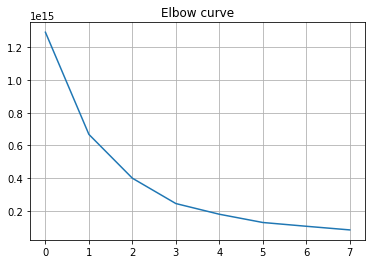

In [9]:
elbow=[]
for i in tqdm( range(2,10)):
    km =KMeans(n_clusters=int(i), init='k-means++', tol=0.0001).fit(Information_cluster.values)
    elbow.append(km.inertia_)
plt.plot(elbow)
plt.grid(True)
plt.title('Elbow curve')
plt.show()



100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [24:48<00:00, 186.07s/it]


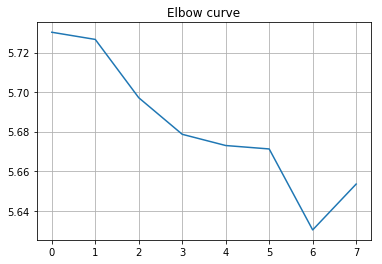

In [10]:
elbow1=[]
for i in tqdm( range(2,10)):
    km =KMeans(n_clusters=int(i), init='k-means++', tol=0.0001).fit(Description_cluster.values)
    elbow1.append(km.inertia_)
plt.plot(elbow)
plt.grid(True)
plt.title('Elbow curve')
plt.show()



After see the result of the plot we have hired that we can set 3 clusters for the Information matrix , for Description matrix we don't have a perfect elbow.

In [21]:
# Using sklearn
km =KMeans(n_clusters=4, init='k-means++', tol=0.0001).fit(Description_cluster)
km1=KMeans(n_clusters=3, init='k-means++', tol=0.0001).fit(Information_cluster)
# Get cluster assignment labels
labels = km.labels_
labels1 = km1.labels_
#put the result of cluster in a dataframe
results = pd.DataFrame([Description_cluster.index,labels]).T
results1 = pd.DataFrame([Information_cluster.index,labels]).T

In [ ]:
final_result=pd.merge(results, results1, on=0)
final_result

In order to see which pair of clusters are the most similar we compute the $Jaccard-similarity$, also known as Intersection over union. We have defined a simple function and and subsequently it was applied to the clusters outputs.

In [120]:
def jaccard(a, b):
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [178]:
#initialize empty dictionary with the size of clusters
d={k:[] for k in range(4)}
d1={k:[] for k in range(3)}

for i,v in enumerate(labels):
    d[v].append(i)
    
for i,v in enumerate(labels1):
    d1[v].append(i)

similarity = []

for cluster1 in d.values():
    for cluster2 in d1.values():
        similarity.append(jaccard(set(cluster1),set(cluster2)))

            

In [179]:
similarity

[0.9155802716747197,
 0.005381738575207516,
 0.078536896834808,
 0.0001990247785849338,
 0.0,
 0.0,
 0.00029853716787740076,
 0.0,
 0.0,
 9.95123892924669e-05,
 0.0,
 0.0]

In [180]:
similarity.sort(reverse=True)
similarity[:3]
Most_relevant=pd.DataFrame(similarity[:3])
Most_relevant

,0
0,0.915580
1,0.078537
2,0.005382
